# **PROGNOSTIC CLASSIFICATION OF RESPIRATORY AILMENTS USING ACOUSTIC ANALYSIS OF LUNG AUSCULTATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
import librosa as lb 
import soundfile as sf
import librosa.display

# **MODULE 1-DATA PREPROCESSING AND DATA VISUALIZATION**

In [ ]:
patient_data=pd.read_csv('/content/drive/MyDrive/RespiratorySoundDatabase/patient_diagnosis.csv',names=['pId','disease'])
patient_data.head()

,pId,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
!pip install pydub

Audio File

In [ ]:
from pydub import AudioSegment
import IPython
path='/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav'
IPython.display.Audio(path)

Text(0.5, 1.0, 'Asthma')

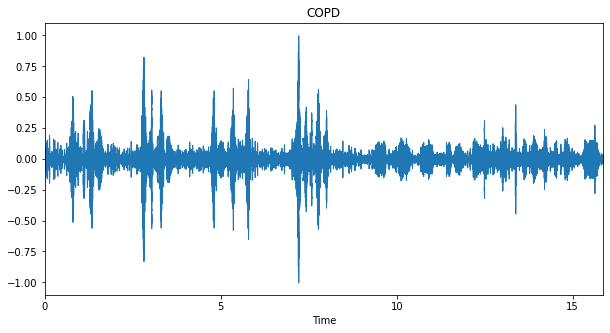

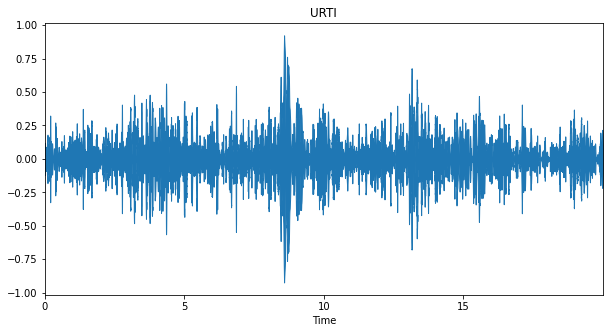

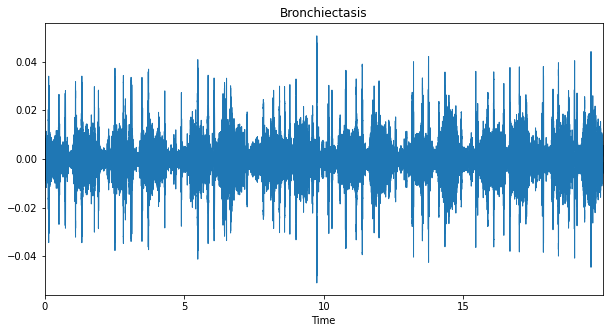

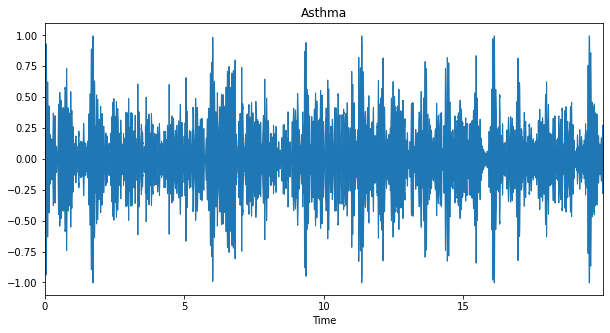

In [ ]:
x,sr=lb.load(path)
plt.figure(figsize=(10,5))
lb.display.waveplot(x,sr=sr)
plt.title('COPD')

y,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/131_1b1_Al_sc_Meditron.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(y,sr=sr)
plt.title('URTI')

z,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/111_1b2_Tc_sc_Meditron.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(z,sr=sr)
plt.title('Bronchiectasis')

p,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(p,sr=sr)
plt.title('Asthma')


Text(0.5, 1.0, 'Healthy')

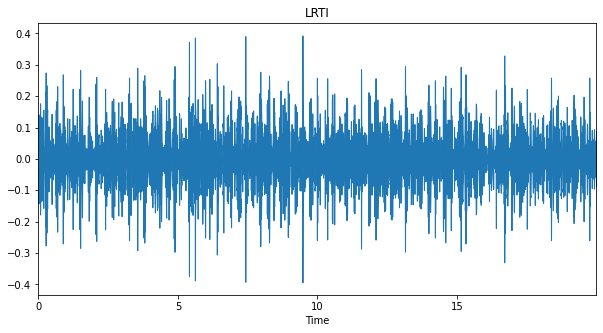

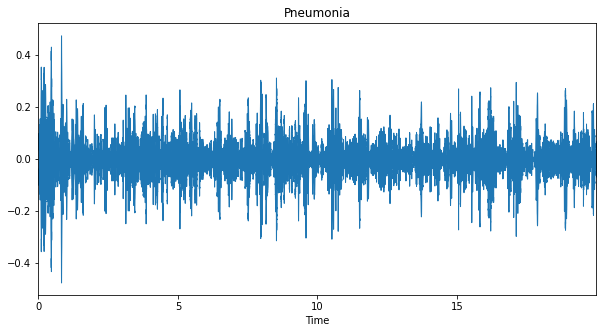

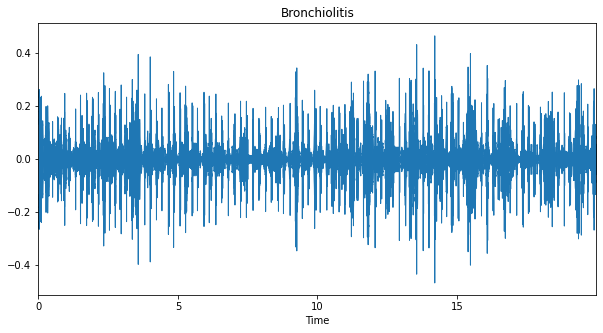

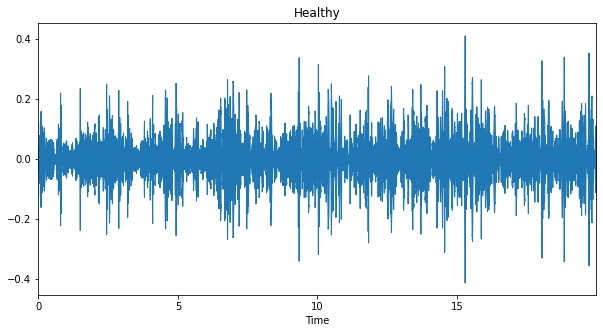

In [ ]:
q,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/108_1b1_Al_sc_Meditron.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(q,sr=sr)
plt.title('LRTI')

r,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/122_2b1_Tc_mc_LittC2SE.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(r,sr=sr)
plt.title('Pneumonia')

s,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/149_1b1_Al_sc_Meditron.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(s,sr=sr)
plt.title('Bronchiolitis')

t,sr=lb.load('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/153_1b1_Al_sc_Meditron.wav')
plt.figure(figsize=(10,5))
lb.display.waveplot(t,sr=sr)
plt.title('Healthy')

In [ ]:
diseases = patient_data['disease'].unique()   #unique diseases
diseases

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

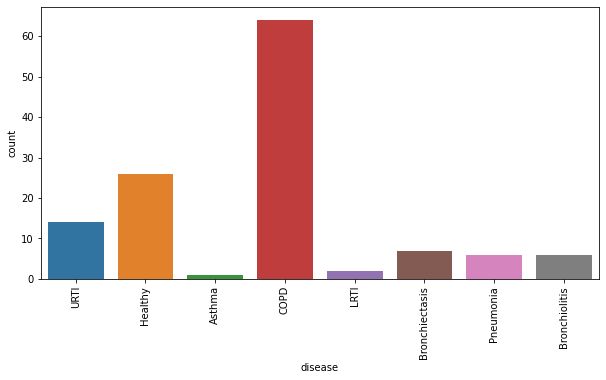

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(patient_data.disease)
plt.xticks(rotation=90)

Annotated File

In [ ]:
AnnotatedFile=pd.read_csv('/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt',sep='\t')
AnnotatedFile.columns=['Start_time','End_time','Crackles','Wheezes']
AnnotatedFile.head()

,Start_time,End_time,Crackles,Wheezes
0,0.579,2.450,0,0
1,2.450,3.893,0,0
2,3.893,5.793,0,0
3,5.793,7.521,0,0
4,7.521,9.279,0,0


In [ ]:
audio_text_loc = '/content/drive/MyDrive/RespiratorySoundDatabase/audio_and_txt_files/'
files = [s.split('.')[0] for s in os.listdir(path = audio_text_loc) if '.txt' in s]    #filename
files[:5]       

['160_1b3_Al_mc_AKGC417L',
 '160_1b3_Lr_mc_AKGC417L',
 '160_1b4_Ar_mc_AKGC417L',
 '160_1b4_Pr_mc_AKGC417L',
 '160_1b3_Pr_mc_AKGC417L']

In [ ]:
len(files)    #length of the total annotated files

920

In [ ]:
def getFilenameInfo(file):
    return file.split('_')           #tokenizing the filename
getFilenameInfo('149_1b1_Al_sc_Meditron')

['149', '1b1', 'Al', 'sc', 'Meditron']

In [ ]:
rec_list=[]
for f in files:
  tokens=getFilenameInfo(f)
  recording_info = pd.DataFrame(data = [tokens], columns=['PatientId', 'RecordingIndex', 'ChestLocation','Acquisition mode','Recording equipment'])
  rec_list.append(recording_info)        #filename dataframe
recording_info=pd.concat(rec_list,ignore_index=True)
recording_info.head()

,PatientId,RecordingIndex,ChestLocation,Acquisition mode,Recording equipment
0,160,1b3,Al,mc,AKGC417L
1,160,1b3,Lr,mc,AKGC417L
2,160,1b4,Ar,mc,AKGC417L
3,160,1b4,Pr,mc,AKGC417L
4,160,1b3,Pr,mc,AKGC417L


Merging the dataframes

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(audio_text_loc + file + '.txt',sep='\t',names=['Start_time','End_time','Crackles','Wheezes'])
    name_data=getFilenameInfo(file)
    data['pId']=name_data[0]
    data['Ac_mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,Start_time,End_time,Crackles,Wheezes,pId,Ac_mode,filename
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L


In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pId      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 4
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start_time  6898 non-null   float64
 1   End_time    6898 non-null   float64
 2   Crackles    6898 non-null   int64  
 3   Wheezes     6898 non-null   int64  
 4   pId         6898 non-null   object 
 5   Ac_mode     6898 non-null   object 
 6   filename    6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


In [ ]:
patient_data.pId=patient_data.pId.astype('int32')   #converting to same datatype
files_df.pId=files_df.pId.astype('int32')    
data = pd.merge(files_df, patient_data, on='pId')
data.head()

,Start_time,End_time,Crackles,Wheezes,pId,Ac_mode,filename,disease
0,1.862,5.718,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
1,5.718,9.725,1,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
2,9.725,13.614,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
3,13.614,17.671,0,1,160,mc,160_1b3_Al_mc_AKGC417L,COPD
4,17.671,19.541,0,0,160,mc,160_1b3_Al_mc_AKGC417L,COPD


In [ ]:
data.sort_values(by=['filename','Start_time'],inplace=True,ascending=[True,True])
data.reset_index(drop=True,inplace=True)
data

,Start_time,End_time,Crackles,Wheezes,pId,Ac_mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
...,...,...,...,...,...,...,...,...
6893,11.721,13.693,1,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6894,13.693,15.536,0,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6895,15.536,17.493,0,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia
6896,17.493,19.436,1,0,226,sc,226_1b1_Pl_sc_LittC2SE,Pneumonia


In [ ]:
data.shape

(6898, 8)

In [ ]:
countdata=data['disease'].value_counts()
print(countdata)

COPD              5746
Healthy            322
Pneumonia          285
URTI               243
Bronchiolitis      160
Bronchiectasis     104
LRTI                32
Asthma               6
Name: disease, dtype: int64


BREATH CYCLE SEGMENTATION 

In [ ]:
def slice_data(start, end, raw_data,  sample_rate):             #slicing into subslices to get pure breathing part of the audio file
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
data['len_per_slice'] = data['End_time'].sub(data['Start_time'], axis = 0) 
max_len_per_slice = max(data['len_per_slice'])     #maximum length per slice
max_len_per_slice

16.163

Outliers

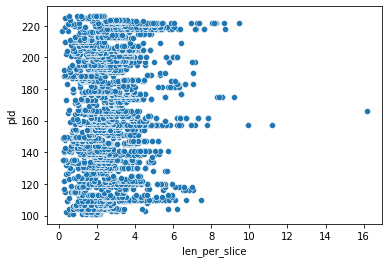

In [ ]:
sns.scatterplot(x=data['len_per_slice'], y=data.pId)

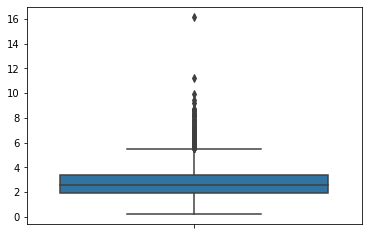

In [ ]:
sns.boxplot(y=(data.End_time-data.Start_time))

In [ ]:
force_max_len = math.ceil(boxplot_stats(data['len_per_slice'])[0]['whishi'])
force_max_len                 #relative maximum length

6

In [ ]:
for disease in diseases:
    path = os.path.join('/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files', disease)
    os.makedirs(path)   #creating the path to save the processed audio files

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 Start_time                        0.036
End_time                          0.579
Crackles                              0
Wheezes                               0
pId                                 101
Ac_mode                              sc
filename         101_1b1_Al_sc_Meditron
disease                            URTI
len_per_slice                     0.543
Name: 0, dtype: object


In [ ]:
i = 0 
c = 0

for index, row in data.iterrows():
    filename = row['filename']
    start = row['Start_time']
    end = row['End_time']
    diag = row['disease']
    
    #check length and force to 6 sec if more than that
    if force_max_len < end - start:
        end = start + force_max_len
    
    audio_file_loc = audio_text_loc + filename + '.wav'
    
    if index > 0:
        if data.iloc[index-1]['filename'] == filename:
            i+=1
        else:
            i=0
    new_filename = filename + '_' + str(i) + '.wav'
    save_path = '/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/' + diag + '/' + new_filename
    
    c+=1
    print('Processing ' + new_filename + '...')

    audioArr, samplingrate = lb.load(audio_file_loc)
    sliced_data = slice_data(start=start, end=end, raw_data=audioArr, sample_rate=samplingrate)

    reqLen=6*samplingrate

    #pad audio if sliced_data length < forced_max_len
    padded_data = lb.util.pad_center(sliced_data, reqLen)
    

    sf.write(file=save_path, data=padded_data, samplerate=samplingrate)
print('Total Files Processed: ',c)

Streaming output truncated to the last 5000 lines.
Processing 138_1p2_Pr_mc_AKGC417L_0.wav...
Processing 138_1p2_Pr_mc_AKGC417L_1.wav...
Processing 138_1p2_Pr_mc_AKGC417L_2.wav...
Processing 138_1p2_Pr_mc_AKGC417L_3.wav...
Processing 138_1p2_Pr_mc_AKGC417L_4.wav...
Processing 138_1p2_Tc_mc_AKGC417L_0.wav...
Processing 138_1p2_Tc_mc_AKGC417L_1.wav...
Processing 138_1p2_Tc_mc_AKGC417L_2.wav...
Processing 138_1p2_Tc_mc_AKGC417L_3.wav...
Processing 138_1p2_Tc_mc_AKGC417L_4.wav...
Processing 138_1p3_Al_mc_AKGC417L_0.wav...
Processing 138_1p3_Al_mc_AKGC417L_1.wav...
Processing 138_1p3_Al_mc_AKGC417L_2.wav...
Processing 138_1p3_Al_mc_AKGC417L_3.wav...
Processing 138_1p3_Al_mc_AKGC417L_4.wav...
Processing 138_1p3_Ar_mc_AKGC417L_0.wav...
Processing 138_1p3_Ar_mc_AKGC417L_1.wav...
Processing 138_1p3_Ar_mc_AKGC417L_2.wav...
Processing 138_1p3_Ar_mc_AKGC417L_3.wav...
Processing 138_1p3_Ar_mc_AKGC417L_4.wav...
Processing 138_1p3_Ll_mc_AKGC417L_0.wav...
Processing 138_1p3_Ll_mc_AKGC417L_1.wav...
Pro

In [ ]:
path='/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/COPD/104_1b1_Al_sc_Litt3200_0.wav'
IPython.display.Audio(path)

# **MODULE 2- FEATURE EXTRACTION (training)**

In [ ]:
def extractId(filename):
    return filename.split('_')[0]     #extracting patient id

In [ ]:
path='/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/'
files_list=[]
for disease in os.listdir(path):
  for file in os.listdir(path+disease+'/'):
    id=extractId(file)
    name=file
    diagnosis=disease
    token=np.array([id,name,diagnosis])
    files_df=pd.DataFrame(data=[token],columns=['pid','filename','diagnosis'])
    files_list.append(files_df)
files_df=pd.concat(files_list,ignore_index=True)
files_df



,pid,filename,diagnosis
0,101,101_1b1_Al_sc_Meditron_0.wav,URTI
1,101,101_1b1_Al_sc_Meditron_1.wav,URTI
2,101,101_1b1_Al_sc_Meditron_2.wav,URTI
3,101,101_1b1_Al_sc_Meditron_3.wav,URTI
4,101,101_1b1_Al_sc_Meditron_4.wav,URTI
...,...,...,...
6568,112,112_1p1_Ll_sc_Litt3200_0.wav,COPD
6569,112,112_1p1_Ll_sc_Litt3200_1.wav,COPD
6570,112,112_1p1_Ll_sc_Litt3200_2.wav,COPD
6571,112,112_1p1_Ll_sc_Litt3200_3.wav,COPD


In [ ]:
files_df.shape

(6573, 3)

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(files_df,files_df.diagnosis,stratify=files_df.diagnosis,random_state=42,test_size=0.25)

In [ ]:
Xtrain.diagnosis.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: diagnosis, dtype: float64

In [ ]:
Xval.diagnosis.value_counts()/Xval.shape[0]

COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: diagnosis, dtype: float64

In [ ]:
Xtrain.to_csv('/content/drive/MyDrive/RespiratorySoundDatabase/train.csv')
Xval.to_csv('/content/drive/MyDrive/RespiratorySoundDatabase/val.csv')

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/RespiratorySoundDatabase/train.csv')
val=pd.read_csv('/content/drive/MyDrive/RespiratorySoundDatabase/val.csv')
train.head()

,Unnamed: 0,pid,filename,diagnosis
0,1984,186,186_2b3_Lr_mc_AKGC417L_3.wav,COPD
1,358,152,152_1b1_Al_sc_Meditron_6.wav,Healthy
2,1044,211,211_1p2_Ar_mc_AKGC417L_10.wav,COPD
3,425,179,179_1b1_Al_sc_Meditron_6.wav,Healthy
4,1783,178,178_1b6_Tc_mc_AKGC417L_2.wav,COPD


In [ ]:
ytrain=train.diagnosis
yval=val.diagnosis
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: diagnosis, Length: 1725, dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [ ]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

Extracting features from data

In [ ]:
root='/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in train.iterrows():
    path=root + row['diagnosis'] +'/' +  row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
print(mfcc_train.shape)
print(cstft_train.shape)
print(mSpec_train.shape)

(5173, 20, 259)
(5173, 12, 259)
(5173, 128, 259)


In [ ]:
root='/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root + row['diagnosis'] +'/' +  row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
print(mfcc_val.shape)
print(cstft_val.shape)
print(mSpec_val.shape)

(1725, 20, 259)
(1725, 12, 259)
(1725, 128, 259)


[Text(0.5, 1.0, 'MFCC')]

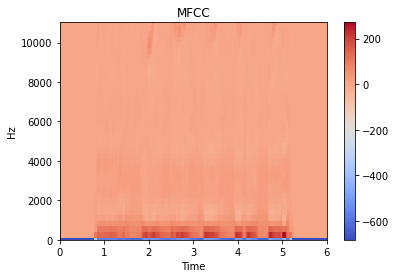

In [ ]:
import librosa.display
file='/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/COPD/104_1b1_Al_sc_Litt3200_4.wav'
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time',y_axis='linear',ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

[Text(0.5, 1.0, 'Chroma')]

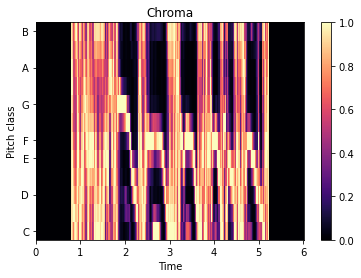

In [ ]:
chromas=lb.feature.chroma_stft(y=sound,sr=sample_rate)
fig, ax = plt.subplots()
img = librosa.display.specshow(chromas, x_axis='time', y_axis='chroma')
fig.colorbar(img, ax=ax)
ax.set(title='Chroma')

[Text(0.5, 1.0, 'Mel-Spectrogram')]

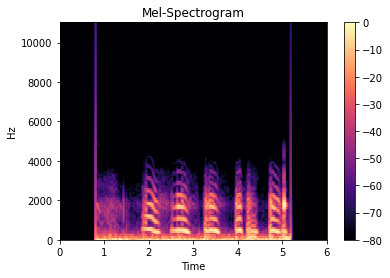

In [ ]:
mSpecs=lb.feature.melspectrogram(y=sound,sr=sample_rate)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.power_to_db(mSpecs,ref=np.max),x_axis='time',y_axis='linear')
fig.colorbar(img, ax=ax)
ax.set(title='Mel-Spectrogram')

MFCC

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

Chroma

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

Mel-spectrogram

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

ENSEMBLED MODEL DEFINING

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

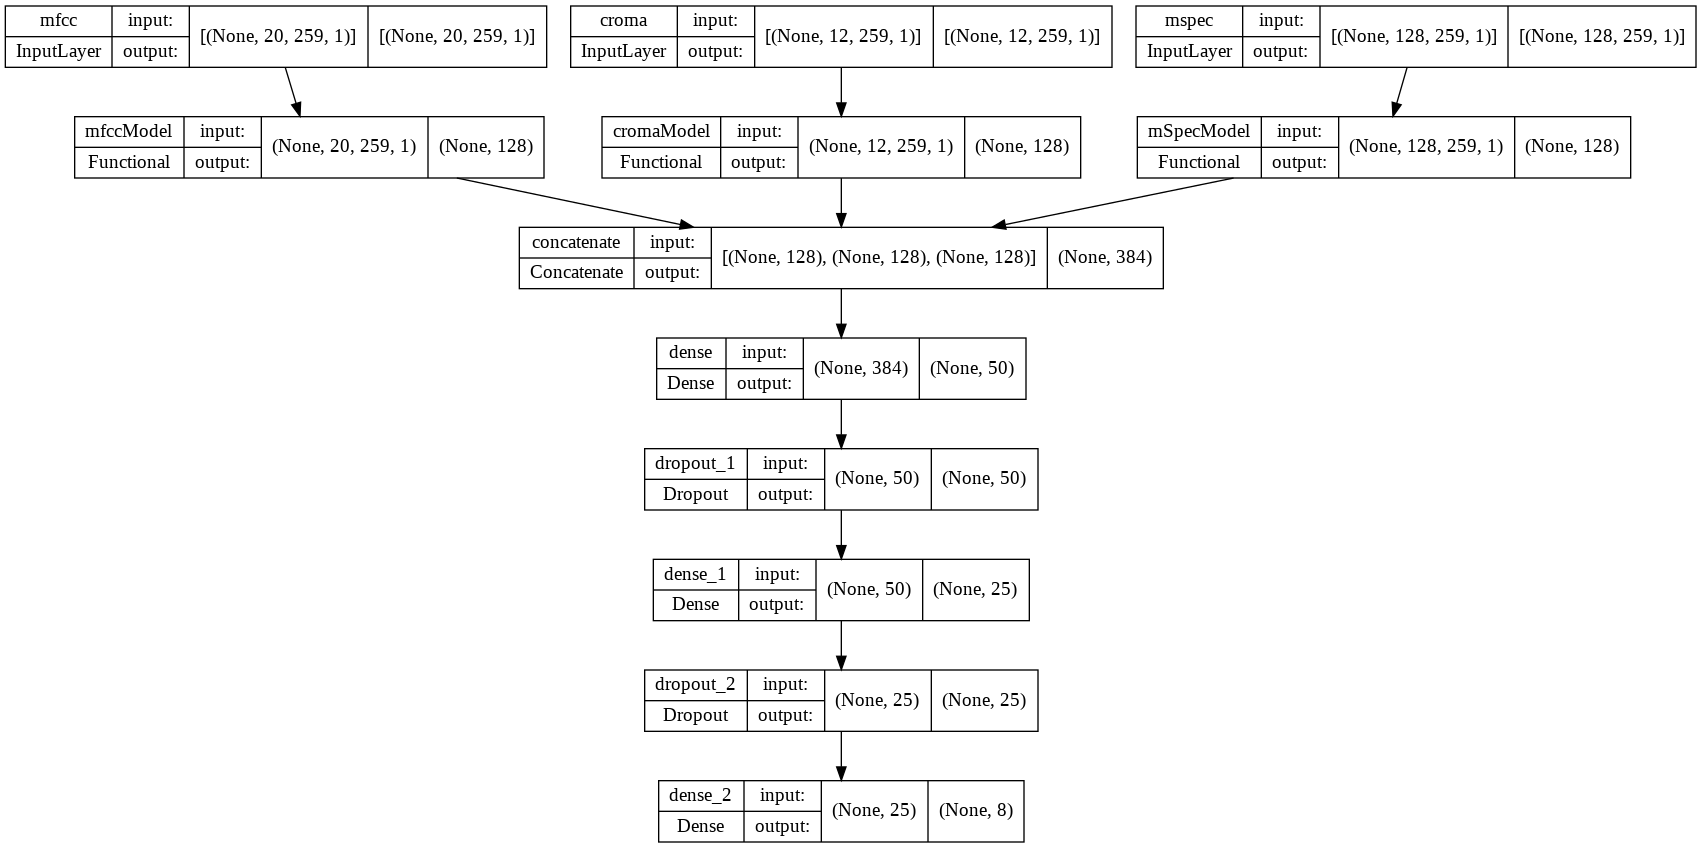

In [ ]:
keras.utils.plot_model(net, "/content/drive/MyDrive/RespiratorySoundDatabase/net.png", show_shapes=True)

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
model_chkpt=ModelCheckpoint('/content/drive/MyDrive/RespiratorySoundDatabase/net.h5',save_best_only=True,monitor='accuracy')


Training the Ensembled model

In [ ]:
INIT_LR=1e-3
EPOCHS=100
BS=128
print("[INFO] compiling model...")
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
net.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print("[INFO] training head...")
history=net.fit({"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,steps_per_epoch=len(Xtrain)//BS,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),validation_steps=len(Xval)//BS,
    epochs=EPOCHS,verbose=1,
    callbacks=[model_chkpt])

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
40/40 [==============================] - 17s 139ms/step - loss: 0.7693 - accuracy: 0.7908 - val_loss: 0.9438 - val_accuracy: 0.7849
Epoch 2/100
40/40 [==============================] - 4s 100ms/step - loss: 0.5292 - accuracy: 0.8299 - val_loss: 0.8477 - val_accuracy: 0.8388
Epoch 3/100
40/40 [==============================] - 4s 100ms/step - loss: 0.4652 - accuracy: 0.8336 - val_loss: 0.7153 - val_accuracy: 0.8377
Epoch 4/100
40/40 [==============================] - 4s 99ms/step - loss: 0.4505 - accuracy: 0.8396 - val_loss: 0.5188 - val_accuracy: 0.8330
Epoch 5/100
40/40 [==============================] - 4s 99ms/step - loss: 0.4236 - accuracy: 0.8419 - val_loss: 0.5000 - val_accuracy: 0.8475
Epoch 6/100
40/40 [==============================] - 4s 100ms/step - loss: 0.3928 - accuracy: 0.8500 - val_loss: 0.4389 - val_accuracy: 0.8383
Epoch 7/100
40/40 [==============================] - 4s 99ms/step - loss: 0.3541 - accuracy: 0.8643 - val_loss: 0.4372 - val_accuracy: 0.8545
E

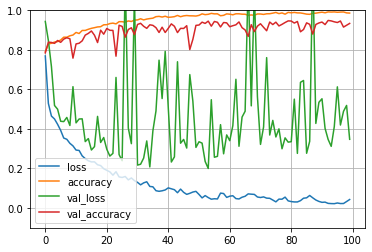

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1)
plt.show()

Accuracy-Ensembled model

In [ ]:
net.evaluate({"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},ytrain)

162/162 [==============================] - 3s 16ms/step - loss: 0.0335 - accuracy: 0.9882


[0.03346167132258415, 0.988207995891571]

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 1s 18ms/step - loss: 0.3477 - accuracy: 0.9339


[0.347676157951355, 0.9339130520820618]

**MODEL COMPARISON**

MFCC ALONE

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
model_chkpt=ModelCheckpoint('/content/drive/MyDrive/RespiratorySoundDatabase/mfcc_model.h5',save_best_only=True,monitor='accuracy')


Training MFCC alone

In [ ]:
INIT_LR=1e-3
EPOCHS=100
BS=128
print("[INFO] compiling model...")
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
mfcc_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print("[INFO] training head...")
history=mfcc_model.fit(mfcc_train,
    ytrain,steps_per_epoch=len(Xtrain)//BS,
    validation_data=(mfcc_val,yval),validation_steps=len(Xval)//BS,
    epochs=EPOCHS,verbose=1,
    callbacks=[model_chkpt])

[INFO] compiling model...
[INFO] training head...
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


40/40 [==============================] - 3s 38ms/step - loss: 4.5284 - accuracy: 0.0087 - val_loss: 4.7077 - val_accuracy: 0.0249
Epoch 2/100
40/40 [==============================] - 1s 28ms/step - loss: 3.6157 - accuracy: 0.3509 - val_loss: 4.3364 - val_accuracy: 0.5345
Epoch 3/100
40/40 [==============================] - 1s 28ms/step - loss: 2.3787 - accuracy: 0.6546 - val_loss: 3.3076 - val_accuracy: 0.6875
Epoch 4/100
40/40 [==============================] - 1s 29ms/step - loss: 1.6691 - accuracy: 0.6982 - val_loss: 2.4702 - val_accuracy: 0.7397
Epoch 5/100
40/40 [==============================] - 1s 29ms/step - loss: 1.3529 - accuracy: 0.7346 - val_loss: 1.9768 - val_accuracy: 0.7646
Epoch 6/100
40/40 [==============================] - 1s 27ms/step - loss: 1.3355 - accuracy: 0.7328 - val_loss: 1.5922 - val_accuracy: 0.7432
Epoch 7/100
40/40 [==============================] - 1s 35ms/step - loss: 1.2031 - accuracy: 0.7419 - val_loss: 1.2052 - val_accuracy: 0.7432
Epoch 8/100
40/40 

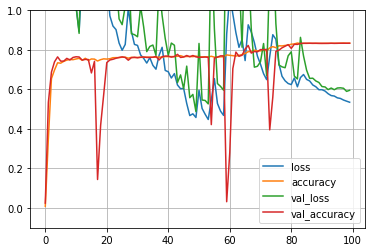

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1)
plt.show()

Accuracy- MFCC alone

In [ ]:
mfcc_model.evaluate(mfcc_train,ytrain)

162/162 [==============================] - 1s 9ms/step - loss: 0.5445 - accuracy: 0.8334


[0.5444706678390503, 0.8333655595779419]

In [ ]:
mfcc_model.evaluate(mfcc_val,yval)

54/54 [==============================] - 1s 10ms/step - loss: 0.5955 - accuracy: 0.8336


[0.5955304503440857, 0.8336231708526611]

# **Feature Extraction**




In [ ]:
import librosa

def feature_chromagram(waveform, sample_rate):
    stft_spectrogram=np.abs(librosa.stft(waveform))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    mfc_coefficients=np.mean(mfcc(waveform, samplerate=sample_rate, winfunc=np.blackman, nfft = 551).T, axis=0)
    return mfc_coefficients

In [ ]:
def get_features(file):
        waveform,sample_rate=lb.load(file)
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        feature_matrix = np.hstack((chromagram, mfc_coefficients))
        
        return feature_matrix

In [ ]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    root='/content/drive/MyDrive/RespiratorySoundDatabase/Segmented_audio_files/'
    for idx,row in files_df.iterrows():
        path=root + row['diagnosis'] +'/' +  row['filename']
        file_name=row['filename']
        diagnosis=row['diagnosis']
        features = get_features(path)
        X.append(features)
        y.append(diagnosis)
        count += 1
    
    return np.array(X), np.array(y)   # features array, labels array

In [ ]:
features, diagnosis = load_data()

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) 
features_df


Audio samples represented: 6898
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.087508,0.085125,0.086448,0.089626,0.091728,0.093686,0.090080,0.089433,0.092328,0.092829,...,0.314937,0.178514,0.125879,0.193659,0.294681,0.320527,0.253670,0.184402,0.173388,0.185489
1,0.273079,0.274123,0.286111,0.300770,0.301964,0.290542,0.278328,0.274077,0.276445,0.277110,...,0.671545,0.480445,0.502694,0.520541,0.456292,0.453010,0.581747,0.694915,0.693292,0.662216
2,0.218426,0.206120,0.211399,0.222623,0.229323,0.233469,0.222945,0.220233,0.220398,0.225807,...,0.167534,0.174177,0.396101,0.581219,0.618077,0.517614,0.317025,0.145893,0.206362,0.534512
3,0.267800,0.270474,0.284983,0.293525,0.301003,0.294962,0.287092,0.286212,0.292211,0.281532,...,0.972221,0.798569,0.597553,0.462774,0.423305,0.439120,0.438005,0.417703,0.459591,0.587830
4,0.253097,0.254469,0.258400,0.268424,0.276650,0.270907,0.260194,0.261101,0.267534,0.270816,...,0.874213,0.753227,0.487351,0.356434,0.503273,0.735148,0.777335,0.640060,0.570022,0.632861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,0.514247,0.506157,0.512434,0.532709,0.558263,0.576696,0.550638,0.529592,0.517186,0.517545,...,2.107182,2.021222,1.889260,1.617791,1.295059,1.063948,0.982289,1.057219,1.169883,1.159105
6894,0.290181,0.285585,0.286750,0.293169,0.305344,0.307735,0.299878,0.299934,0.303436,0.304747,...,1.214470,1.141742,1.108684,1.050354,0.937091,0.821371,0.779996,0.791053,0.773164,0.688069
6895,0.348580,0.347127,0.356950,0.369752,0.381909,0.399198,0.381403,0.371123,0.364162,0.355659,...,1.552584,1.411857,1.303163,1.245379,1.159732,1.014835,0.880767,0.824804,0.830642,0.834302
6896,0.314763,0.317904,0.324538,0.337115,0.351684,0.340531,0.325112,0.325716,0.326696,0.319629,...,1.286792,1.277563,1.141617,0.898228,0.696400,0.687034,0.845626,0.975042,0.912281,0.689225


In [ ]:
features_diagnosis=pd.DataFrame(features,diagnosis)
features_diagnosis

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
URTI,0.087508,0.085125,0.086448,0.089626,0.091728,0.093686,0.090080,0.089433,0.092328,0.092829,...,0.314937,0.178514,0.125879,0.193659,0.294681,0.320527,0.253670,0.184402,0.173388,0.185489
URTI,0.273079,0.274123,0.286111,0.300770,0.301964,0.290542,0.278328,0.274077,0.276445,0.277110,...,0.671545,0.480445,0.502694,0.520541,0.456292,0.453010,0.581747,0.694915,0.693292,0.662216
URTI,0.218426,0.206120,0.211399,0.222623,0.229323,0.233469,0.222945,0.220233,0.220398,0.225807,...,0.167534,0.174177,0.396101,0.581219,0.618077,0.517614,0.317025,0.145893,0.206362,0.534512
URTI,0.267800,0.270474,0.284983,0.293525,0.301003,0.294962,0.287092,0.286212,0.292211,0.281532,...,0.972221,0.798569,0.597553,0.462774,0.423305,0.439120,0.438005,0.417703,0.459591,0.587830
URTI,0.253097,0.254469,0.258400,0.268424,0.276650,0.270907,0.260194,0.261101,0.267534,0.270816,...,0.874213,0.753227,0.487351,0.356434,0.503273,0.735148,0.777335,0.640060,0.570022,0.632861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bronchiolitis,0.514247,0.506157,0.512434,0.532709,0.558263,0.576696,0.550638,0.529592,0.517186,0.517545,...,2.107182,2.021222,1.889260,1.617791,1.295059,1.063948,0.982289,1.057219,1.169883,1.159105
Bronchiolitis,0.290181,0.285585,0.286750,0.293169,0.305344,0.307735,0.299878,0.299934,0.303436,0.304747,...,1.214470,1.141742,1.108684,1.050354,0.937091,0.821371,0.779996,0.791053,0.773164,0.688069
Bronchiolitis,0.348580,0.347127,0.356950,0.369752,0.381909,0.399198,0.381403,0.371123,0.364162,0.355659,...,1.552584,1.411857,1.303163,1.245379,1.159732,1.014835,0.880767,0.824804,0.830642,0.834302
Bronchiolitis,0.314763,0.317904,0.324538,0.337115,0.351684,0.340531,0.325112,0.325716,0.326696,0.319629,...,1.286792,1.277563,1.141617,0.898228,0.696400,0.687034,0.845626,0.975042,0.912281,0.689225


In [ ]:
features_diagnosis.to_csv('/content/drive/MyDrive/RespiratorySoundDatabase/features_disease.csv')

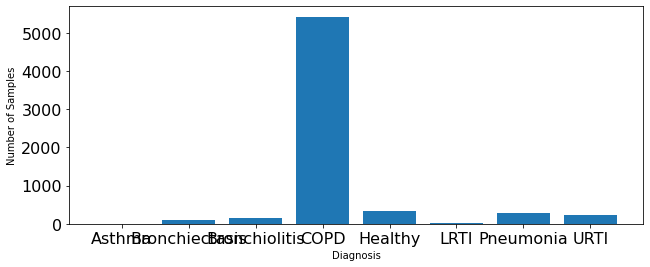

In [ ]:
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)

diagnosis_list, count = np.unique(diagnosis, return_counts=True)
plt.bar(x=range(8), height=count)
plt.xticks(ticks=range(8), labels = [diagnosis for diagnosis in diagnosis_list],fontsize=10)
plt.xlabel('Diagnosis')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
new_names =['diagnosis', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179']
df = pd.read_csv(
    '/content/drive/MyDrive/RespiratorySoundDatabase/features_disease.csv', 
    names=new_names,           
    header=0)
df_reorder = df[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179','diagnosis']]
df_reorder
df_reorder.to_csv('/content/drive/MyDrive/RespiratorySoundDatabase/features_disease_reorder.csv',index=False)

DATA BALANCING

Class=7, n=243 (3.518%)
Class=4, n=323 (4.676%)
Class=0, n=15 (0.217%)
Class=3, n=5746 (83.179%)
Class=5, n=32 (0.463%)
Class=1, n=104 (1.506%)
Class=6, n=285 (4.126%)
Class=2, n=160 (2.316%)


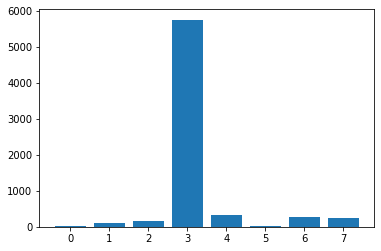

In [ ]:
from pandas import read_csv
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

url = '/content/drive/MyDrive/RespiratorySoundDatabase/features_disease_reorder.csv'

df = read_csv(url, header=0)
data = df.values

X, y = data[:, :-1], data[:, -1]

y = LabelEncoder().fit_transform(y)             # label encode the target variable

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (5746) in class 3 will be larger than the number of samples in the majority class (class #3 -> 4613)
  f"After over-sampling, the number of samples ({n_samples})"


Class=3, n=5746 (62.146%)
Class=6, n=500 (5.408%)
Class=1, n=500 (5.408%)
Class=4, n=500 (5.408%)
Class=7, n=500 (5.408%)
Class=2, n=500 (5.408%)
Class=5, n=500 (5.408%)
Class=0, n=500 (5.408%)


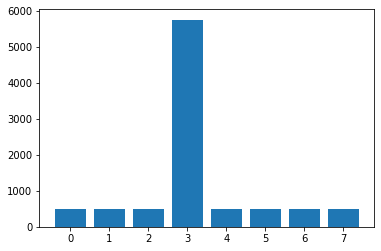

In [ ]:

from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,random_state=42,test_size=0.2)


from imblearn.over_sampling import SMOTE
from collections import Counter

strategy = {0:500, 1:500, 2:500, 3:5746, 4:500, 5:500, 6:500, 7:500}
oversample = SMOTE(sampling_strategy=strategy)
Xsmote, ysmote = oversample.fit_resample(Xtrain, ytrain)
import numpy as np

counter = Counter(ysmote)
for k,v in counter.items():
	per = v / len(ysmote) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
Xsmote,ysmote

(array([[ 0.35638592,  0.39099538,  0.40828022, ..., -0.58388084,
         -0.26960048,  1.7780069 ],
        [ 0.47388473,  0.47240517,  0.47558042, ...,  1.0421963 ,
         -0.3652894 ,  0.7734662 ],
        [ 0.26905948,  0.2694617 ,  0.27759868, ...,  0.8632781 ,
          0.9780511 ,  0.59640753],
        ...,
        [ 0.38397423,  0.40150574,  0.4188507 , ...,  1.24636929,
          0.88144151,  1.11572494],
        [ 0.17286572,  0.1721252 ,  0.17592534, ...,  0.45750459,
          0.42746763,  0.29850088],
        [ 0.26442059,  0.25896383,  0.26592079, ...,  0.91636046,
          0.1082676 ,  0.91229288]]), array([3, 3, 6, ..., 7, 7, 7]))

In [ ]:
import pandas as pd
feature_array=pd.DataFrame(Xsmote)
feature_array

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.356386,0.390995,0.408280,0.378855,0.340033,0.324921,0.315887,0.306212,0.308592,0.340493,...,1.922994,2.511903,1.956047,1.606814,-0.364267,-1.412333,-1.697652,-0.583881,-0.269600,1.778007
1,0.473885,0.472405,0.475580,0.464911,0.458809,0.451562,0.444835,0.442579,0.443410,0.445784,...,-0.616835,1.060160,-0.428305,1.188913,0.208532,1.040520,-0.173757,1.042196,-0.365289,0.773466
2,0.269059,0.269462,0.277599,0.280405,0.273104,0.263317,0.257131,0.257150,0.259898,0.271664,...,0.544909,0.289613,0.858685,1.292429,0.858242,0.222124,0.320529,0.863278,0.978051,0.596408
3,0.549492,0.547513,0.556292,0.566840,0.564596,0.547863,0.546169,0.547632,0.547168,0.555455,...,-0.533314,2.339387,0.329658,2.271409,-0.281081,2.446932,0.596337,2.483156,0.178120,2.128756
4,0.507515,0.515932,0.512558,0.513669,0.514224,0.484559,0.483090,0.479711,0.481621,0.473671,...,0.849011,1.072580,0.230976,-0.331926,-0.219581,0.702315,1.359282,1.137334,1.340591,0.525098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241,0.271355,0.276977,0.285706,0.290026,0.290082,0.292169,0.282609,0.275169,0.270167,0.268883,...,0.927813,0.344355,0.171348,0.438453,0.793510,0.974365,0.925338,0.714654,0.580728,0.672170
9242,0.156965,0.157414,0.160734,0.166720,0.165004,0.163553,0.160696,0.157115,0.154463,0.155654,...,0.396000,0.272053,0.339503,0.427792,0.498343,0.470950,0.380490,0.365209,0.440861,0.421128
9243,0.383974,0.401506,0.418851,0.426069,0.414163,0.408782,0.397952,0.400253,0.398029,0.388092,...,0.995385,1.019890,1.046043,1.418580,1.140484,1.512414,1.114560,1.246369,0.881442,1.115725
9244,0.172866,0.172125,0.175925,0.181695,0.183689,0.184880,0.180496,0.178600,0.175034,0.176502,...,0.559394,0.387453,0.350486,0.401266,0.423414,0.410142,0.419721,0.457505,0.427468,0.298501


Feature Scaling

In [ ]:
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:12]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
  
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}') 

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:140]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()

    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:180]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()

    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')
    
print_features(feature_array)

12 Chromagram features:           min = 0.006,     max = 5630.819,     mean = 21.111,     deviation = 145.407

128 Mel Spectrogram features:     min = -945.165,     max = 9550.542,     mean = -0.738,     deviation = 68.305

40 MFCC features:                 min = -945.165,    max = 189.118,    mean = -8.016,    deviation = 82.161


In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

Xtrain_features_scaled = Xsmote 
Xtrain_features_scaled = scaler.fit_transform(Xtrain_features_scaled)

Xtest_features_scaled = Xtest
Xtest_features_scaled = scaler.fit_transform(Xtest_features_scaled)



In [ ]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
Xtrain_features_scaled_df = pd.DataFrame(Xtrain_features_scaled)
print_features(Xtrain_features_scaled_df)
print('\n\n')
Xtest_features_scaled_df = pd.DataFrame(Xtest_features_scaled)
print_features(Xtest_features_scaled_df)


Standard Scaling:

12 Chromagram features:           min = -2.162,     max = 11.763,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -4.125,     max = 93.791,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -6.055,    max = 11.242,    mean = -0.000,    deviation = 1.000



12 Chromagram features:           min = -2.167,     max = 9.160,     mean = -0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -4.237,     max = 37.095,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.865,    max = 8.132,    mean = 0.000,    deviation = 1.000


# **Module-3 Classification Model Training**

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from pandas import read_csv

from sklearn.model_selection import train_test_split


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers import Embedding, LSTM, Bidirectional,SimpleRNN,GRU,CuDNNGRU
from keras.layers.convolutional import MaxPooling1D
from keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical

In [ ]:
Xtrain=Xtrain_features_scaled
Xtest=Xtest_features_scaled
ytrain=ysmote

In [ ]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((9246, 180), (1382, 180), (9246,), (1382,))

In [ ]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)  

ytrain = np.reshape(ytrain, (ytrain.shape[0], 8))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
ytest = np.reshape(ytest, (ytest.shape[0], 8))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtrain.shape[1],  1))

In [ ]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((9246, 180, 1), (1382, 180, 1), (9246, 8), (1382, 8))

1D CNNs-FCNs model

In [ ]:

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Xtrain.shape[1],1)))
model.add(MaxPooling1D(pool_size=10))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=10))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 178, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17, 64)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 17, 64)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 64)            12352     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)            

In [ ]:

from tensorflow.python.keras.callbacks import ModelCheckpoint
model_chkpoint=ModelCheckpoint('/content/drive/MyDrive/RespiratorySoundDatabase/CNN_FCN_3_6.h5',monitor='accuracy')
epochs,batch_size,verbose = 100, 64, 1
history=model.fit(Xtrain, ytrain, steps_per_epoch=len(Xtrain)//batch_size,validation_data=(Xtest,ytest),validation_steps=len(Xtest)//batch_size,epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[model_chkpoint])

Epoch 1/100
36/36 [==============================] - 8s 201ms/step - loss: 0.8958 - accuracy: 0.6809 - val_loss: 0.5998 - val_accuracy: 0.8133
Epoch 2/100
36/36 [==============================] - 7s 194ms/step - loss: 0.6065 - accuracy: 0.7792 - val_loss: 0.5182 - val_accuracy: 0.8367
Epoch 3/100
36/36 [==============================] - 7s 189ms/step - loss: 0.5449 - accuracy: 0.8007 - val_loss: 0.4435 - val_accuracy: 0.8602
Epoch 4/100
36/36 [==============================] - 7s 192ms/step - loss: 0.4615 - accuracy: 0.8335 - val_loss: 0.4422 - val_accuracy: 0.8539
Epoch 5/100
36/36 [==============================] - 7s 189ms/step - loss: 0.4131 - accuracy: 0.8517 - val_loss: 0.4508 - val_accuracy: 0.8297
Epoch 6/100
36/36 [==============================] - 7s 189ms/step - loss: 0.3815 - accuracy: 0.8628 - val_loss: 0.4121 - val_accuracy: 0.8469
Epoch 7/100
36/36 [==============================] - 7s 198ms/step - loss: 0.3535 - accuracy: 0.8726 - val_loss: 0.4287 - val_accuracy: 0.8617

Accuracy: 90%
Loss: 0.4163



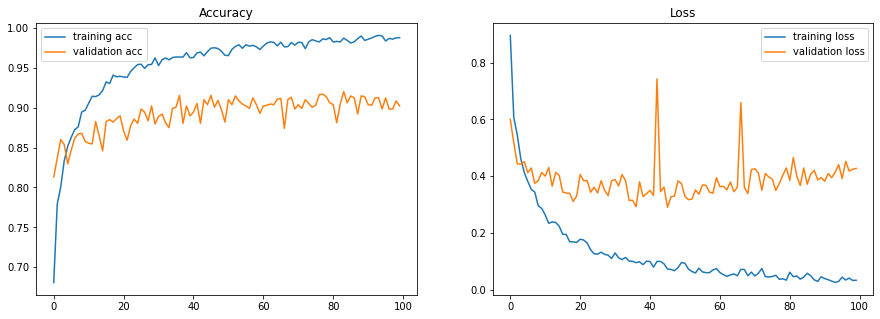

In [ ]:

score = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

Performance metrics

[[   2    0    0    0    0    0    0    0]
 [   0   14    0    5    0    0    0    0]
 [   0    0    8    3    9    2    0    8]
 [   1    4    8 1088   14    0   10    8]
 [   0    0    1    6   66    0    0    6]
 [   0    0    0    1    3    1    0    1]
 [   0    0    0   13    7    0   33    3]
 [   0    1    4    4   10    0    1   37]]



                precision    recall  f1-score   support

        Asthma       0.67      1.00      0.80         2
Bronchiectasis       0.74      0.74      0.74        19
 Bronchiolitis       0.38      0.27      0.31        30
          COPD       0.97      0.96      0.97      1133
       Healthy       0.61      0.84      0.70        79
          LRTI       0.33      0.17      0.22         6
     Pneumoina       0.75      0.59      0.66        56
          URTI       0.59      0.65      0.62        57

      accuracy                           0.90      1382
     macro avg       0.63      0.65      0.63      1382
  weighted avg       0.91      0.9

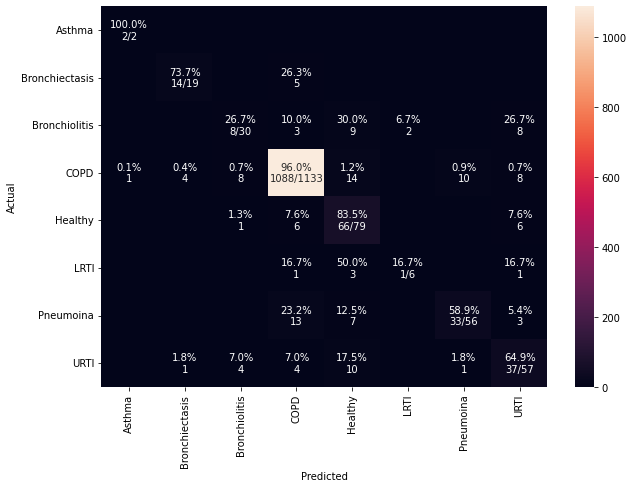

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import seaborn as sn
matrix_index = ["Asthma","Bronchiectasis","Bronchiolitis","COPD", "Healthy", "LRTI" , "Pneumoina", "URTI"]

preds = model.predict(Xtest)
classpreds = np.argmax(preds, axis=1) # predicted classes 
ytestclass = np.argmax(ytest, axis=1) # true classes

cm = confusion_matrix(ytestclass, classpreds)
print(cm)
print('\n\n')
print(classification_report(ytestclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

Cohen's kappa score

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen=cohen_kappa_score(ytestclass,classpreds)
cohen

0.7060435035016145

Matthews correlation coefficient

In [ ]:
from sklearn.metrics import matthews_corrcoef
mat=matthews_corrcoef(ytestclass,classpreds)
mat

0.7069380449549276

GRU Model

In [ ]:
model_g = Sequential()
model_g.add(GRU(128,input_shape=(Xtrain.shape[1],1)))
model_g.add(Dropout(0.02))
model_g.add(Dense(50,activation = 'tanh'))
model_g.add(Dropout(0.04))
model_g.add(Dense(8, activation ='softmax')) # output
model_g.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

model_g.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               50304     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 50)                6450      
                                                                 
 dropout_14 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 8)                 408       
                                                                 
Total params: 57,162
Trainable params: 57,162
Non-trainable params: 0
_________________________________________________________________


In [ ]:

from tensorflow.python.keras.callbacks import ModelCheckpoint
model_chkpoint=ModelCheckpoint('/content/drive/MyDrive/RespiratorySoundDatabase/model_GRU_1.h5',monitor='accuracy')
epochs,batch_size,verbose = 100, 64, 1
history=model_g.fit(Xtrain, ytrain, steps_per_epoch=len(Xtrain)//batch_size,validation_data=(Xtest,ytest),validation_steps=len(Xtest)//batch_size,epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[model_chkpoint])

Epoch 1/100
36/36 [==============================] - 27s 596ms/step - loss: 1.5717 - accuracy: 0.5614 - val_loss: 0.9062 - val_accuracy: 0.7820
Epoch 2/100
36/36 [==============================] - 21s 603ms/step - loss: 1.2510 - accuracy: 0.6328 - val_loss: 0.9076 - val_accuracy: 0.7820
Epoch 3/100
36/36 [==============================] - 22s 604ms/step - loss: 1.1938 - accuracy: 0.6507 - val_loss: 0.8164 - val_accuracy: 0.8070
Epoch 4/100
36/36 [==============================] - 21s 593ms/step - loss: 1.0966 - accuracy: 0.6675 - val_loss: 0.7794 - val_accuracy: 0.8047
Epoch 5/100
36/36 [==============================] - 23s 645ms/step - loss: 0.9746 - accuracy: 0.6773 - val_loss: 0.7050 - val_accuracy: 0.7914
Epoch 6/100
36/36 [==============================] - 22s 607ms/step - loss: 0.8755 - accuracy: 0.7071 - val_loss: 0.6686 - val_accuracy: 0.7875
Epoch 7/100
36/36 [==============================] - 25s 682ms/step - loss: 0.8055 - accuracy: 0.7306 - val_loss: 0.6241 - val_accuracy:

Accuracy: 90%
Loss: 0.5391



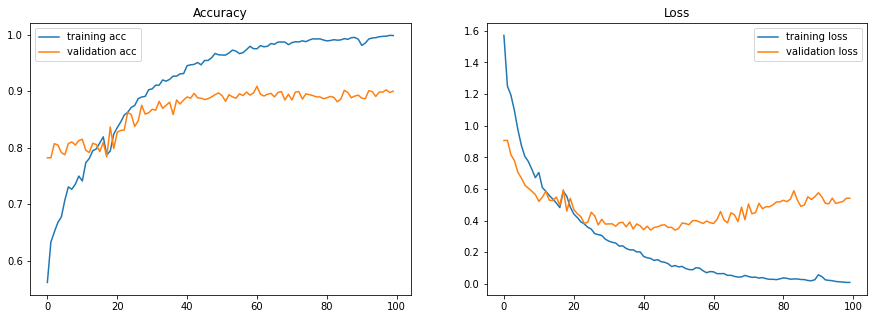

In [ ]:

score = model_g.evaluate(Xtest, ytest, batch_size=batch_size, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

[[   2    0    0    0    0    0    0    0]
 [   0   12    1    6    0    0    0    0]
 [   0    0   16    3    5    0    1    5]
 [   1    3    7 1074   12    1   17   18]
 [   0    0    2    8   64    0    1    4]
 [   0    0    1    1    1    3    0    0]
 [   0    0    2   12    6    0   33    3]
 [   0    0    4    4    5    1    2   41]]



                precision    recall  f1-score   support

        Asthma       0.67      1.00      0.80         2
Bronchiectasis       0.80      0.63      0.71        19
 Bronchiolitis       0.48      0.53      0.51        30
          COPD       0.97      0.95      0.96      1133
       Healthy       0.69      0.81      0.74        79
          LRTI       0.60      0.50      0.55         6
     Pneumoina       0.61      0.59      0.60        56
          URTI       0.58      0.72      0.64        57

      accuracy                           0.90      1382
     macro avg       0.67      0.72      0.69      1382
  weighted avg       0.91      0.9

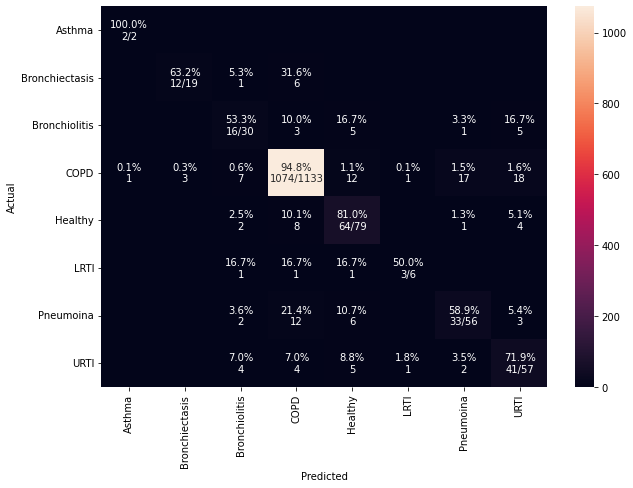

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import seaborn as sn
matrix_index = ["Asthma","Bronchiectasis","Bronchiolitis","COPD", "Healthy", "LRTI" , "Pneumoina", "URTI"]
from tensorflow.keras.models import load_model
model_g=load_model('/content/drive/MyDrive/RespiratorySoundDatabase/model_GRU_1.h5')
preds_g = model_g.predict(Xtest)
classpreds_g = np.argmax(preds_g, axis=1) # predicted classes 
ytestclass_g = np.argmax(ytest, axis=1) # true classes

cm = confusion_matrix(ytestclass_g, classpreds_g)
print(cm)
print('\n\n')
print(classification_report(ytestclass_g, classpreds_g, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen=cohen_kappa_score(ytestclass_g,classpreds_g)   #cohen's kappa score
cohen


0.7036242762170277

In [ ]:
from sklearn.metrics import matthews_corrcoef
mat=matthews_corrcoef(ytestclass_g,classpreds_g)  #matthews correlation coeff
mat

0.7047867702356047

Hybrid CNN-GRU Model


In [ ]:
model_cg = Sequential()
model_cg.add(Conv1D(filters = 64, kernel_size = 3,activation='relu',input_shape=(Xtrain.shape[1],1)))
model_cg.add(BatchNormalization())
model_cg.add(Dropout(0.5))
model_cg.add(GRU(128))
model_cg.add(Dropout(0.02))
model_cg.add(Dense(100,activation = 'tanh'))
model_cg.add(Dropout(0.04))
model_cg.add(Dense(8, activation ='softmax')) # output
model_cg.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])

model_cg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 64)           256       
                                                                 
 batch_normalization (BatchN  (None, 178, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 178, 64)           0         
                                                                 
 gru (GRU)                   (None, 128)               74496     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 100)               12900     
                                                        

In [ ]:

from tensorflow.python.keras.callbacks import ModelCheckpoint
model_chkpoint=ModelCheckpoint('/content/drive/MyDrive/RespiratorySoundDatabase/model_CNN_GRU.h5',monitor='accuracy')
epochs,batch_size,verbose = 100, 64, 1
history=model_cg.fit(Xtrain, ytrain, steps_per_epoch=len(Xtrain)//batch_size,validation_data=(Xtest,ytest),validation_steps=len(Xtest)//batch_size,epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[model_chkpoint])

Epoch 1/100
36/36 [==============================] - 37s 955ms/step - loss: 1.2748 - accuracy: 0.6123 - val_loss: 0.9517 - val_accuracy: 0.8094
Epoch 2/100
36/36 [==============================] - 33s 945ms/step - loss: 1.0118 - accuracy: 0.6846 - val_loss: 0.8521 - val_accuracy: 0.8094
Epoch 3/100
36/36 [==============================] - 33s 914ms/step - loss: 0.8991 - accuracy: 0.7080 - val_loss: 0.7567 - val_accuracy: 0.8164
Epoch 4/100
36/36 [==============================] - 33s 916ms/step - loss: 0.7840 - accuracy: 0.7340 - val_loss: 0.7505 - val_accuracy: 0.8180
Epoch 5/100
36/36 [==============================] - 33s 915ms/step - loss: 0.6658 - accuracy: 0.7681 - val_loss: 0.7145 - val_accuracy: 0.8148
Epoch 6/100
36/36 [==============================] - 33s 914ms/step - loss: 0.5846 - accuracy: 0.7920 - val_loss: 0.7439 - val_accuracy: 0.8180
Epoch 7/100
36/36 [==============================] - 34s 932ms/step - loss: 0.5318 - accuracy: 0.8122 - val_loss: 1.0360 - val_accuracy:

Accuracy: 92%
Loss: 0.3282



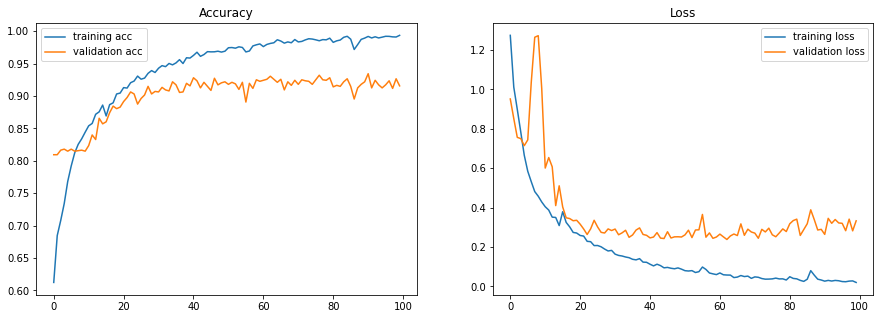

In [ ]:

score = model_cg.evaluate(Xtest, ytest, batch_size=batch_size, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

[[   2    0    0    0    0    0    0    0]
 [   0   16    0    2    1    0    0    0]
 [   0    1   23    1    1    1    0    3]
 [   1    7   12 1076    8    1   12   16]
 [   0    0    6    1   61    0    3    8]
 [   0    0    0    0    0    6    0    0]
 [   0    0    6    7    5    0   35    3]
 [   0    0    3    1    3    0    2   48]]



                precision    recall  f1-score   support

        Asthma       0.67      1.00      0.80         2
Bronchiectasis       0.67      0.84      0.74        19
 Bronchiolitis       0.46      0.77      0.57        30
          COPD       0.99      0.95      0.97      1133
       Healthy       0.77      0.77      0.77        79
          LRTI       0.75      1.00      0.86         6
     Pneumoina       0.67      0.62      0.65        56
          URTI       0.62      0.84      0.71        57

      accuracy                           0.92      1382
     macro avg       0.70      0.85      0.76      1382
  weighted avg       0.93      0.9

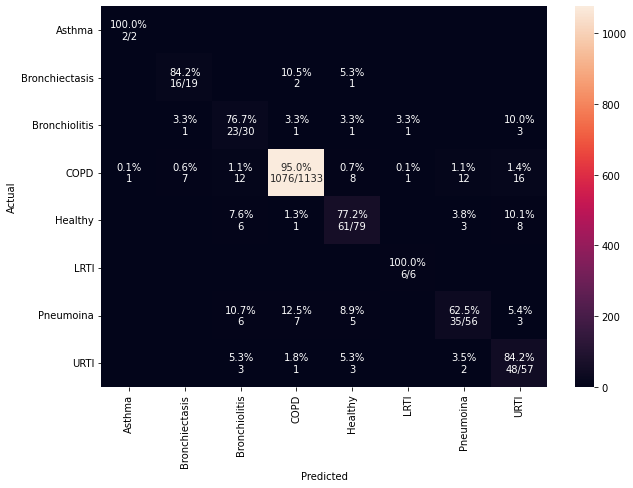

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import seaborn as sn
matrix_index = ["Asthma","Bronchiectasis","Bronchiolitis","COPD", "Healthy", "LRTI" , "Pneumoina", "URTI"]

preds_cg = model_cg.predict(Xtest)
classpreds_cg = np.argmax(preds_cg, axis=1) # predicted classes 
ytestclass_cg = np.argmax(ytest, axis=1) # true classes

cm = confusion_matrix(ytestclass_cg, classpreds_cg)
print(cm)
print('\n\n')
print(classification_report(ytestclass_cg, classpreds_cg, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen=cohen_kappa_score(ytestclass_cg,classpreds_cg) #cohen's kappa score
cohen

0.7597833167828225

In [ ]:
from sklearn.metrics import matthews_corrcoef
mat=matthews_corrcoef(ytestclass_cg,classpreds_cg)  #matthews' correlation coeff
mat

0.7634669848258546